# Binning

Try to improve the performance of a classifier on `data` with the following conditions:

1. use binning and comment on its effects
1. use a test on the raw (unbalanced) data and comment the results (compare with a test on the balanced data)
1. use at least 2 other preprocessing techniques (your choice!) on the data set and comment the results
1. create a short report on all the steps and results

In [1]:
import pandas
import numpy
import itertools
from pprint import pprint 
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
from sklearn.metrics import confusion_matrix, f1_score
from matplotlib import pyplot
from sklearn.base import clone
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
%matplotlib inline

## Credit Card Data

See https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients.

Note that the data does not follow the data description below.

### Attribute Information

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:

- *X1*: amount of the given credit (NT dollar), it includes both the individual consumer credit and his/her family (supplementary) credit
- *X2*: gender (1 = male, 2 = female)
- *X3*: education (1 = graduate school, 2 = university, 3 = high school, 4 = others) 
- *X4*: marital status (1 = married, 2 = single, 3 = others) 
- *X5*: age (year)
- *X6-X11*: history of past payment, we tracked the past monthly payment records (from April 2005 to September 2005) as follows: X6 = the repayment status in September 2005, X7 = the repayment status in August 2005, ..., X11 = the repayment status in April 2005, the measurement scale for the repayment status is: -1 = pay duly, 1 = payment delay for one month, 2 = payment delay for two months, ..., 8 = payment delay for eight months, 9 = payment delay for nine months and above
- *X12-X17*: amount of bill statement (NT dollar), X12 = amount of bill statement in September, 2005, X13 = amount of bill statement in August 2005, ..., X17 = amount of bill statement in April 2005
- *X18-X23*: amount of previous payment (NT dollar), X18 = amount paid in September 2005, X19 = amount paid in August 2005, ..., X23 = amount paid in April 2005 

In [3]:
# Yeh, I. C., & Lien, C. H. (2009).
# The comparisons of data mining techniques for the predictive accuracy
# of probability of default of credit card clients.
# Expert Systems with Applications, 36(2), 2473-2480.
data = pandas.read_csv('data/defaul-of-credit-card-clients.csv', sep=';')
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
X1       30000 non-null int64
X2       30000 non-null int64
X3       30000 non-null int64
X4       30000 non-null int64
X5       30000 non-null int64
X6       30000 non-null int64
X7       30000 non-null int64
X8       30000 non-null int64
X9       30000 non-null int64
X10      30000 non-null int64
X11      30000 non-null int64
X12      30000 non-null int64
X13      30000 non-null int64
X14      30000 non-null int64
X15      30000 non-null int64
X16      30000 non-null int64
X17      30000 non-null int64
X18      30000 non-null int64
X19      30000 non-null int64
X20      30000 non-null int64
X21      30000 non-null int64
X22      30000 non-null int64
X23      30000 non-null int64
class    30000 non-null int64
dtypes: int64(24)
memory usage: 5.5 MB


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,class
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [4]:
class_names = [0, 1]
data['class'].value_counts()

0    23364
1     6636
Name: class, dtype: int64

In [5]:
# 'X3' attribute should only be {1, 2, 3, 4}
data['X3'].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: X3, dtype: int64

In [6]:
def dataset_split(data):
    X = data.drop('class', axis=1)
    y = data['class']
    # by setting the random_state the test set is going to be unseen
    # because the split is going to be the same all the time
    X_tr, X_va, y_tr, y_va = train_test_split(X, y, random_state=37)
    X_tr, X_te, y_tr, y_te = train_test_split(X_tr, y_tr, random_state=37)
    return X_tr, X_va, X_te, y_tr, y_va, y_te

X_tr, X_va, X_te, y_tr, y_va, y_te = dataset_split(data)

In [7]:
y_tr.shape, y_va.shape, y_te.shape

((16875,), (7500,), (5625,))

## Binning

It does *not* make sense to bin:

- X2: gender (1 = male, 2 = female)
- X3: education (1 = graduate school, 2 = university, 3 = high school, 4 = others)
- X4: marital status (1 = married, 2 = single, 3 = others)

It does make sense to bin:

- X1: amount of the given credit (NT dollar), it includes both the individual consumer credit and his/her family (supplementary) credit
- X5: age (year)

It does make sense to bin the ranges of these attributes the same:

- *X6-X11*: history of past payment, we tracked the past monthly payment records (from April 2005 to September 2005) as follows: X6 = the repayment status in September 2005, X7 = the repayment status in August 2005, ..., X11 = the repayment status in April 2005, the measurement scale for the repayment status is: -1 = pay duly, 1 = payment delay for one month, 2 = payment delay for two months, ..., 8 = payment delay for eight months, 9 = payment delay for nine months and above
- *X12-X17*: amount of bill statement (NT dollar), X12 = amount of bill statement in September, 2005, X13 = amount of bill statement in August 2005, ..., X17 = amount of bill statement in April 2005
- *X18-X23*: amount of previous payment (NT dollar), X18 = amount paid in September 2005, X19 = amount paid in August 2005, ..., X23 = amount paid in April 2005

Although I will do binning on all atributes and see if this idea is valid.

### Classifiers

These are taken as **black boxes**. Inspired by http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html. I have chosen these because their are not computably demanding and are known to me.

To see which is best without balancing they are evaluated below using F1 score:

$$ F_1 = 2 \cdot \frac{\textit{precision} \cdot \textit{recall}}{\textit{precision} + \textit{recall}} $$

In [8]:
clfs = {
    '3NN\t': KNeighborsClassifier(3),
    'Decision Tree': DecisionTreeClassifier(max_depth=5),
    'Neural Net': MLPClassifier(alpha=1),
    'Naive Bayes': GaussianNB(),
}
pprint(clfs)

{'3NN\t': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform'),
 'Decision Tree': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
 'Naive Bayes': GaussianNB(priors=None),
 'Neural Net': MLPClassifier(activation='relu', alpha=1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose

In [9]:
def eval_clf(X_tr, y_tr, X_va=X_va, y_va=y_va):
    for name, clf in clfs.items():
        clf = clone(clf)
        y_pred = clf.fit(X_tr, y_tr).predict(X_va)
        f1 = f1_score(y_va, y_pred)
        print(name, '\t', f1)

def balance(X_tr, y_tr):
    # balance already splited data
    return SMOTEENN(random_state=37).fit_sample(X_tr, y_tr)

Without balancing and scaling the Decision Tree model is best.

In [10]:
eval_clf(X_tr, y_tr)

3NN	 	 0.285098743268
Decision Tree 	 0.460481099656
Neural Net 	 0.0726315789474
Naive Bayes 	 0.396298312466


Balancing with SMOTEENN improves all but Naive Bayes model.

In [11]:
X_ba, y_ba = balance(X_tr, y_tr)
eval_clf(X_ba, y_ba)

3NN	 	 0.401823281907
Decision Tree 	 0.50295588904
Neural Net 	 0.407933884298
Naive Bayes 	 0.388554586762


Scaling improves significantly all model but Decision Tree has lower F1 score.

In [12]:
scaler = StandardScaler()
X_tr_ = scaler.fit_transform(X_tr)
X_va_ = scaler.transform(X_va)
eval_clf(X_tr_, y_tr, X_va_)

3NN	 	 0.415042735043
Decision Tree 	 0.460656990069
Neural Net 	 0.425273390036
Naive Bayes 	 0.503840245776


Both preprocessing procedures (balancing and scaling) are good from Decision Tree, 3NN, Neural Net but not for Naive Bayes model.

In [13]:
X_ba, y_ba = balance(X_tr, y_tr)
scaler = StandardScaler()
X_ba_ = scaler.fit_transform(X_ba)
X_va_ = scaler.transform(X_va)
eval_clf(X_ba_, y_ba, X_va_)

3NN	 	 0.462324393359
Decision Tree 	 0.50295588904
Neural Net 	 0.487843447322
Naive Bayes 	 0.397462454687


From the result presented above I will make maybe bad decision. The best algorithm so far seems to be Naive Bayes applied to unbalanced but scaled data. So for binnig I will use this model.

Second best is Decision Tree. For this model binning should have little effect cause splitting the data into bins is nearly what the model does.

In [14]:
# scaling
scaler = StandardScaler()
X_tr_ = scaler.fit_transform(X_tr)
X_va_ = scaler.transform(X_va)
# classification
clf = GaussianNB()
y_pred = clf.fit(X_tr_, y_tr).predict(X_va_)
# evaluation
f1_base = f1_score(y_va, y_pred)
cm = confusion_matrix(y_va, y_pred)
norm_cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]
print(norm_cm)
print('f1 score baseline:', f1_base)

[[ 0.78713893  0.21286107]
 [ 0.41567696  0.58432304]]
f1 score baseline: 0.503840245776


## The Approach

I will try to bin 1 attribute at a time and evaluate the performance. To try combanition would be to large problem. I will compare each result to base line F1 score which is shown above. For each attribute I try 50 numbers of bins uniformly spaced between 2 and number of unique items in the attribute's values.

### Equal Width

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.cut.html

In [15]:
def change_column(df, attribute, series):
    """Changes a attribute in dataframe."""
    new_df = df.copy()
    new_df[attribute] = series
    return new_df

def validate_nb(X_tr, y_tr, X_va, y_va):
    """Return F1 validation score of Naive Bayes data on X_tr, y_tr."""
    y_pred = GaussianNB().fit(X_tr, y_tr).predict(X_va)
    return f1_score(y_va, y_pred)

def equal_width_attr(attr_range, attr):
    attr_range = list(set(map(int, attr_range)))
    
    f1s = []
    for bins in attr_range:
        scaler = StandardScaler()
        # train attribute
        X_ = pandas.cut(X_tr[attr], bins=bins, labels=False)
        X_tr_ = scaler.fit_transform(change_column(X_tr, attr, X_))
        # validation attribute
        X_ = pandas.cut(X_va[attr], bins=bins, labels=False)
        X_va_ = scaler.transform(change_column(X_va, attr, X_))
        # evaluate
        f1s.append(validate_nb(X_tr_, y_tr, X_va_, y_va))
    
    # show results
    pyplot.scatter(attr_range, f1s)
    pyplot.axhline(f1_base, color='red')
    pyplot.xticks(rotation='vertical')
    pyplot.show()
    
    # get best binning
    index = numpy.argmax(f1s)
    return attr_range[index], f1s[index]

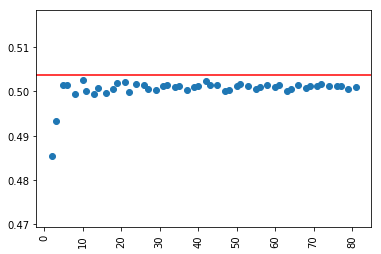

X1 best bins: 10 best f1: 0.502486260141


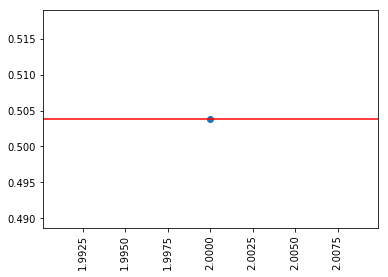

X2 best bins: 2 best f1: 0.503840245776


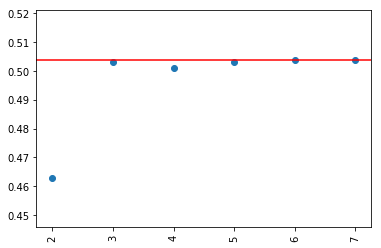

X3 best bins: 7 best f1: 0.503840245776


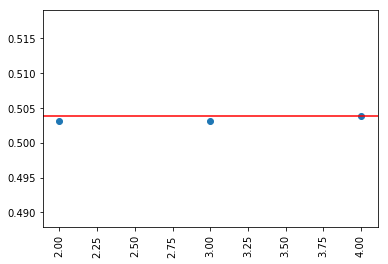

X4 best bins: 4 best f1: 0.503840245776


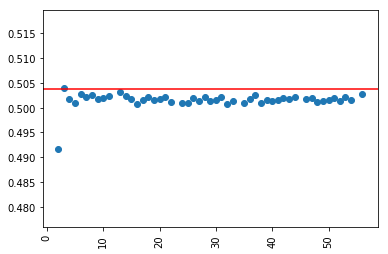

X5 best bins: 3 best f1: 0.503937007874


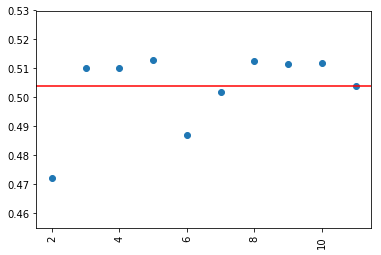

X6 best bins: 5 best f1: 0.512663085188


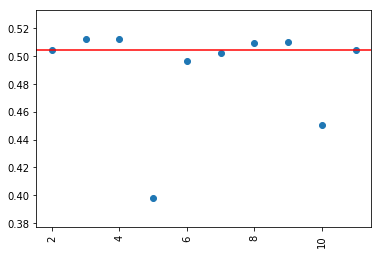

X7 best bins: 3 best f1: 0.511904761905


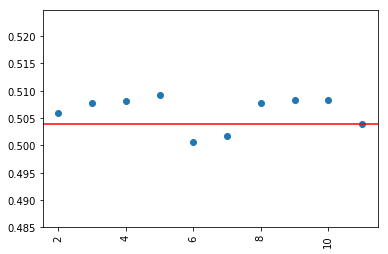

X8 best bins: 5 best f1: 0.509189189189


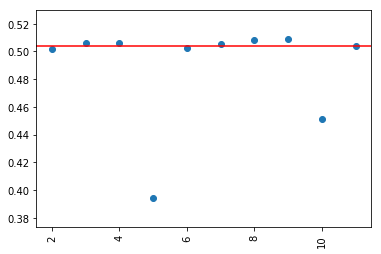

X9 best bins: 9 best f1: 0.509090909091


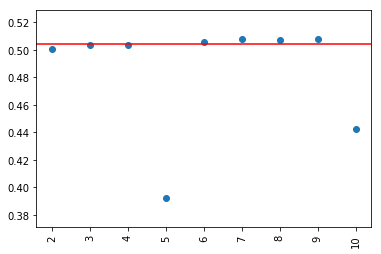

X10 best bins: 9 best f1: 0.507970818698


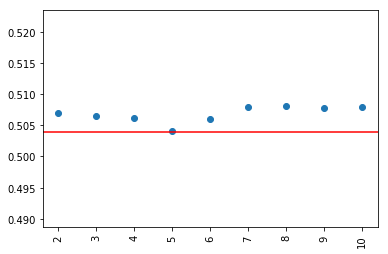

X11 best bins: 8 best f1: 0.508113860069


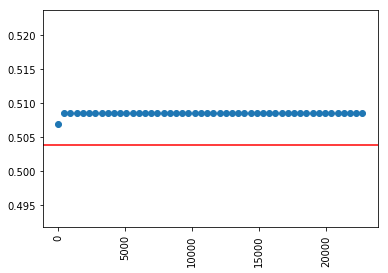

X12 best bins: 20868 best f1: 0.50851970181


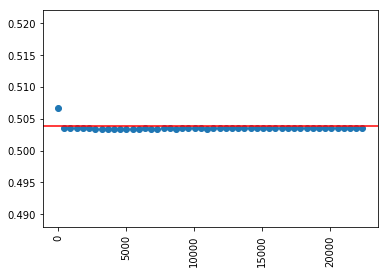

X13 best bins: 2 best f1: 0.506666666667


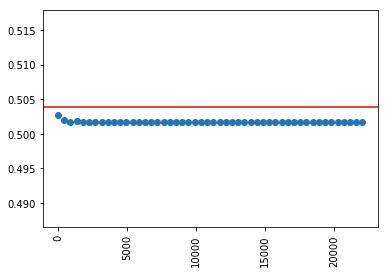

X14 best bins: 2 best f1: 0.502706883217


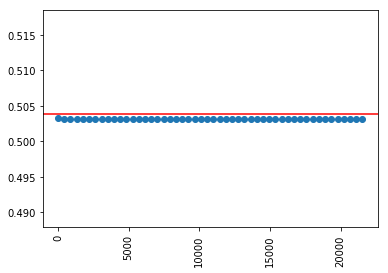

X15 best bins: 2 best f1: 0.503328213006


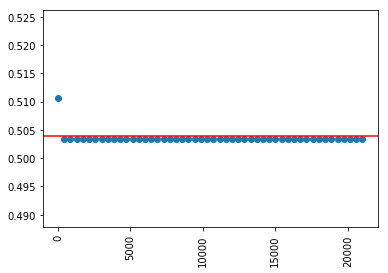

X16 best bins: 2 best f1: 0.510672358591


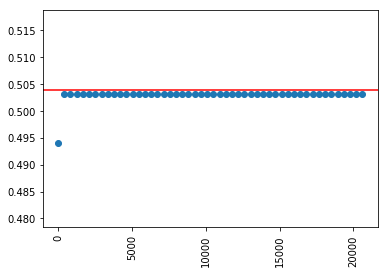

X17 best bins: 5888 best f1: 0.503083247688


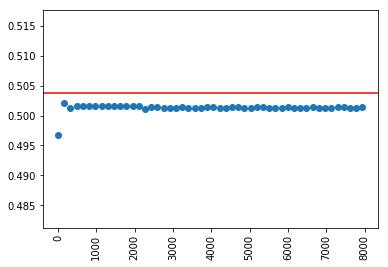

X18 best bins: 164 best f1: 0.502155718996


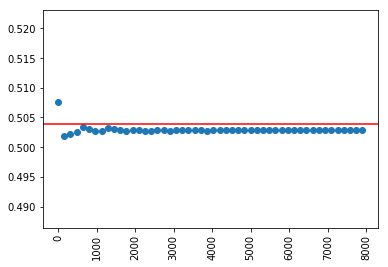

X19 best bins: 2 best f1: 0.507592190889


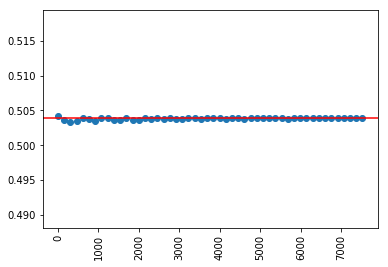

X20 best bins: 2 best f1: 0.504191962995


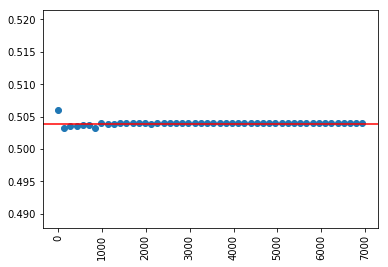

X21 best bins: 2 best f1: 0.506086506087


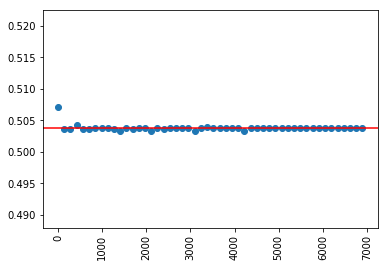

X22 best bins: 2 best f1: 0.507056978568


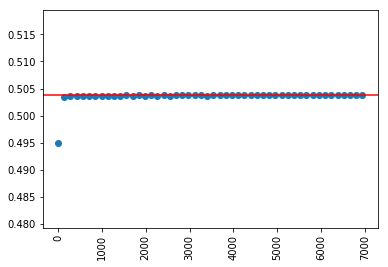

X23 best bins: 2691 best f1: 0.503840245776


In [16]:
for attribute in X_tr.columns:
    best_bin, best_f1 = equal_width_attr(numpy.linspace(2, data[attribute].nunique()), attribute)
    print(attribute, 'best bins:', best_bin, 'best f1:', best_f1)

Results above show the equal width binning is bad approach it cannot impore F1 score significantly. But I will try if there is a combine effect. Best numbers of bins

- for X6 number of bins 5
- for X7 number of bins 5
- for X8 number of bins 3
- for X9 number of bins 9
- for X10 number of bins 9
- for X11 number of bins 8
- for X12 number of bins 20868
- for X13 number of bins 2
- for X16 number of bins 2
- for X19 number of bins 2
- for X20 number of bins 2
- for X21 number of bins 2
- for X22 number of bins 2

In [17]:
X_tr_, X_va_ = X_tr.copy(), X_va.copy()
for attr, bins in [('X6', 5), ('X7', 5), ('X8', 3), ('X9', 9), ('X10', 9),\
                   ('X11', 8), ('X12', 20868), ('X13', 2), ('X16', 2),\
                   ('X19', 2), ('X20', 2), ('X21', 2), ('X22', 2)]:
    X_ = pandas.cut(X_tr[attr], bins=bins, labels=False)
    X_tr_ = change_column(X_tr_, attr, X_)
    X_ = pandas.cut(X_va[attr], bins=bins, labels=False)
    X_va_ = change_column(X_va_, attr, X_)

# scaling
scaler = StandardScaler()
X_tr_ = scaler.fit_transform(X_tr_)
X_va_ = scaler.transform(X_va_)
# classification
clf = GaussianNB()
y_pred = clf.fit(X_tr_, y_tr).predict(X_va_)
# evaluation
f1 = f1_score(y_va, y_pred)
cm = confusion_matrix(y_va, y_pred)
norm_cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]
print(norm_cm)
print('f1 score baseline:', f1)

[[ 0.80605227  0.19394773]
 [ 0.44714964  0.55285036]]
f1 score baseline: 0.497461928934


Nope there is no combine effect. The F1 score is even worse.

### Equal Height (Equal Depth)

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.qcut.html

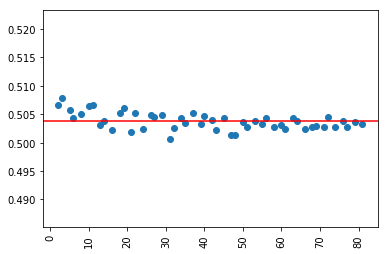

X1 best bins: 3 best f1: 0.507854751481


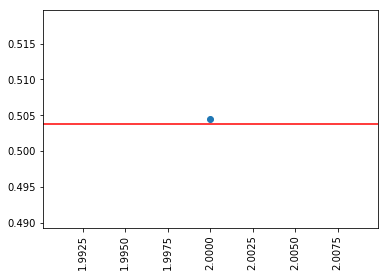

X2 best bins: 2 best f1: 0.504476848299


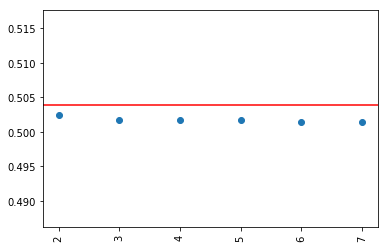

X3 best bins: 2 best f1: 0.502417918045


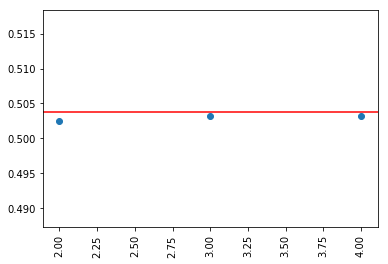

X4 best bins: 3 best f1: 0.503196113526


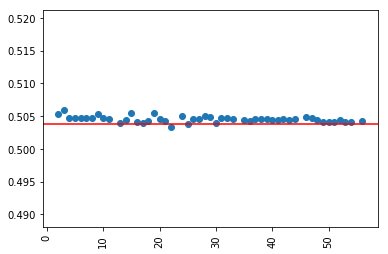

X5 best bins: 3 best f1: 0.50591868245


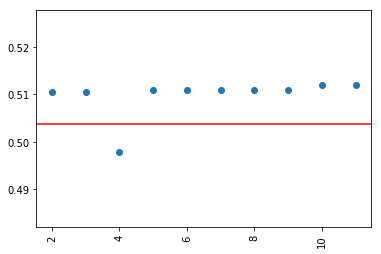

X6 best bins: 10 best f1: 0.511882998172


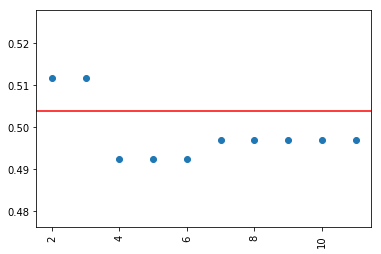

X7 best bins: 2 best f1: 0.511753580113


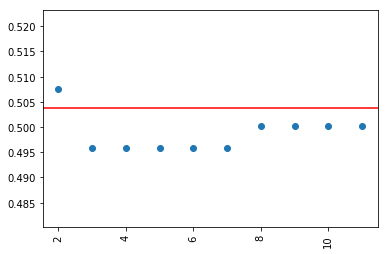

X8 best bins: 2 best f1: 0.507510729614


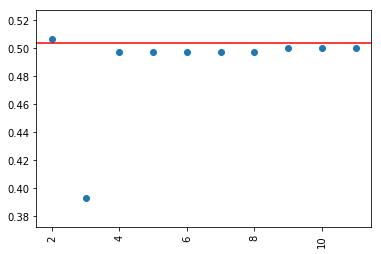

X9 best bins: 2 best f1: 0.506412005457


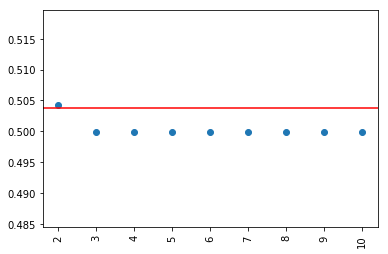

X10 best bins: 2 best f1: 0.504280585474


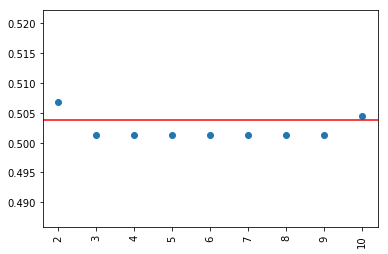

X11 best bins: 2 best f1: 0.506826870563


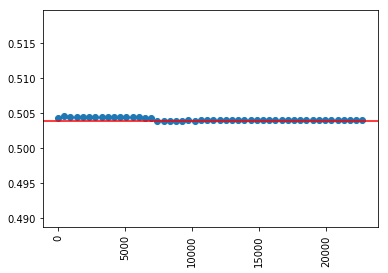

X12 best bins: 465 best f1: 0.504486029223


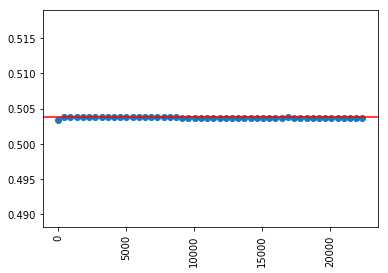

X13 best bins: 7298 best f1: 0.503844182471


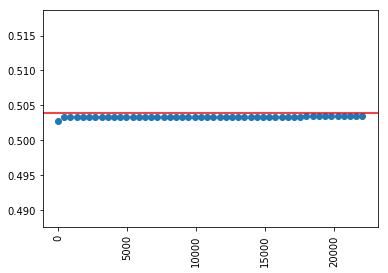

X14 best bins: 19329 best f1: 0.503464203233


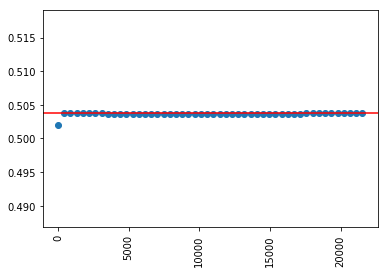

X15 best bins: 441 best f1: 0.503852080123


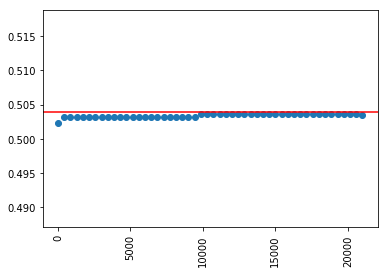

X16 best bins: 18437 best f1: 0.503582395087


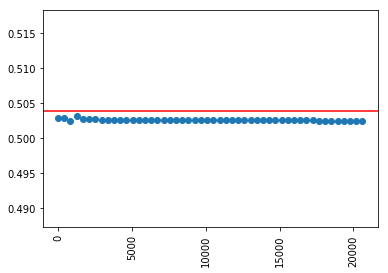

X17 best bins: 1263 best f1: 0.503080082136


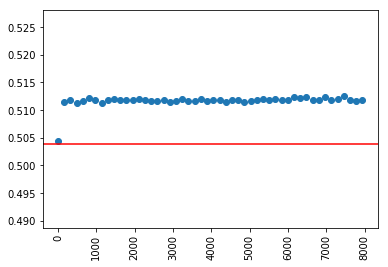

X18 best bins: 7456 best f1: 0.512465373961


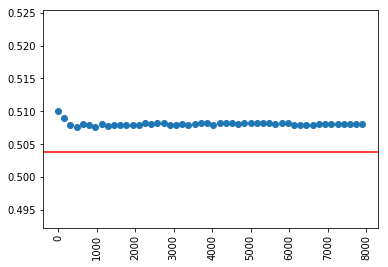

X19 best bins: 2 best f1: 0.510081743869


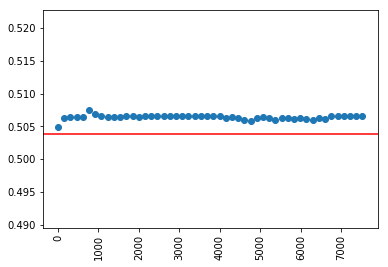

X20 best bins: 768 best f1: 0.507408370159


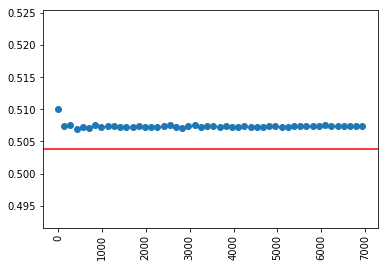

X21 best bins: 2 best f1: 0.510077936039


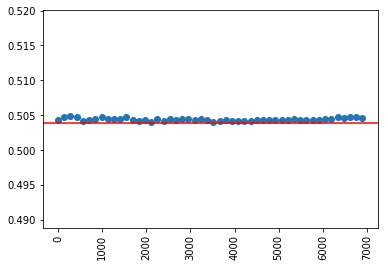

X22 best bins: 283 best f1: 0.504839131572


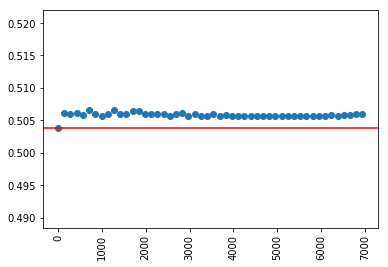

X23 best bins: 709 best f1: 0.506652752413


In [18]:
def equal_height_attr(attr_range, attr):
    attr_range = list(set(map(int, attr_range)))
    
    f1s = []
    for q in attr_range:
        scaler = StandardScaler()
        X_ = pandas.qcut(X_tr[attr], q=q, labels=False, duplicates='drop')
        X_tr_ = scaler.fit_transform(change_column(X_tr, attr, X_))
        X_ = pandas.qcut(X_va[attr], q=q, labels=False, duplicates='drop')
        X_va_ = scaler.transform(change_column(X_va, attr, X_))
        f1 = validate_nb(X_tr_, y_tr, X_va_, y_va)
        f1s.append(f1)

    pyplot.scatter(attr_range, f1s)
    pyplot.axhline(f1_base, color='red')
    pyplot.xticks(rotation='vertical')
    pyplot.show()
    
    # get best binning
    index = numpy.argmax(f1s)
    return attr_range[index], f1s[index]

for attribute in X_tr.columns:
    best_bin, best_f1 = equal_height_attr(numpy.linspace(2, data[attribute].nunique()), attribute)
    print(attribute, 'best bins:', best_bin, 'best f1:', best_f1)

The same as for equal width. No significant improvement.

## PCA

In [19]:
X_tr.shape

(16875, 23)

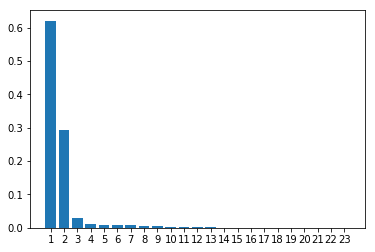

In [20]:
pca = PCA(n_components=23)
X_pca = pca.fit_transform(X_tr)
pyplot.bar(range(1, 24), pca.explained_variance_ratio_)
_ = pyplot.xticks(range(1, 24))

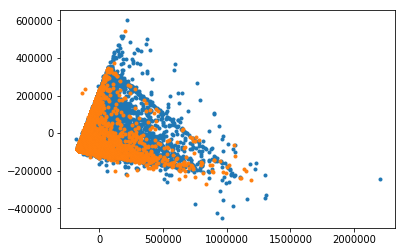

In [21]:
x = X_pca[:, 0]
y = X_pca[:, 1]
for label in [0, 1]:
    index = y_tr == label
    pyplot.scatter(x[index], y[index], marker='.')

In [22]:
for components in range(1, 24):
    scaler = StandardScaler()
    X_tr_ = scaler.fit_transform(X_pca[:, :components])
    X_va_ = scaler.transform(pca.transform(X_va)[:, :components])
    clf = clone(clfs['Naive Bayes'])
    y_pred = clf.fit(X_tr_, y_tr).predict(X_va_)
    f1 = f1_score(y_va, y_pred)
    print(components, '\t', f1)

/home/podondra/mi-pdd/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/podondra/mi-pdd/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/podondra/mi-pdd/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/podondra/mi-pdd/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/podondra/mi-pdd/venv/lib/python3.6/sit

1 	 0.0
2 	 0.0
3 	 0.0
4 	 0.0
5 	 0.0
6 	 0.384473197782
7 	 0.396075823079
8 	 0.391667889101
9 	 0.389402859546
10 	 0.387721691678
11 	 0.387744179823
12 	 0.387234042553
13 	 0.386029898135
14 	 0.386806199497
15 	 0.388783011163
16 	 0.398535417547
17 	 0.399661064821
18 	 0.406415538552
19 	 0.424012638231
20 	 0.438490057297
21 	 0.439049064239
22 	 0.440460081191
23 	 0.461195692536


PCA as proprocessing procedure to select features does not help to improve.

## Confusion Matrix of Test Set

In [23]:
scaler = StandardScaler()
X_tr_ = scaler.fit_transform(X_tr)
clf = GaussianNB()
clf.fit(X_tr_, y_tr)
y_pred = clf.predict(scaler.transform(X_te))
cm = confusion_matrix(y_te, y_pred)
norm_cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]
print(norm_cm)
print(f1_score(y_te, y_pred))

[[ 0.78161698  0.21838302]
 [ 0.40517962  0.59482038]]
0.495132127955


## Conclusion Reportults

Binning is not a good preprocessing producedure for this data according to this work. I was not able to observe any significant improvement of prediction.

I found that from my choosen classifier best model is Naive Bayes on unbalanced but scaled data.

I applied two preprocessing techniques scaling and PCA. Scaling helped to improve prediction significantly. I wanted to use PCA to reduce the number of features but it does not provide improvement.